<a href="https://colab.research.google.com/github/harnalashok/classification/blob/main/10_vowpalWabbit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/kashnitsky/vowpal-wabbit-tutorial-blazingly-fast-learning

In [1]:
!git clone --recursive https://github.com/VowpalWabbit/vowpal_wabbit.git 
!cd vowpal_wabbit/; make 
!cd vowpal_wabbit/; make install 

Cloning into 'vowpal_wabbit'...
remote: Enumerating objects: 71418, done.
remote: Counting objects: 100% (2107/2107), done.
remote: Compressing objects: 100% (1113/1113), done.
remote: Total 71418 (delta 1360), reused 1435 (delta 973), pack-reused 69311
Receiving objects: 100% (71418/71418), 133.10 MiB | 25.04 MiB/s, done.
Resolving deltas: 100% (53115/53115), done.
Submodule 'ext_libs/fmt' (https://github.com/fmtlib/fmt.git) registered for path 'ext_libs/fmt'
Submodule 'rapidjson' (https://github.com/Tencent/rapidjson.git) registered for path 'ext_libs/rapidjson'
Submodule 'ext_libs/spdlog' (https://github.com/gabime/spdlog.git) registered for path 'ext_libs/spdlog'
Cloning into '/content/vowpal_wabbit/ext_libs/fmt'...
remote: Enumerating objects: 26801, done.        
remote: Counting objects: 100% (509/509), done.        
remote: Compressing objects: 100% (176/176), done.        
remote: Total 26801 (delta 291), reused 458 (delta 278), pack-reused 26292        
Receiving objects: 100

In [2]:
!vw --help

driver:
  --onethread           Disable parse thread
VW options:
  --ring_size arg (=256, ) size of example ring
  --strict_parse           throw on malformed examples
Update options:
  -l [ --learning_rate ] arg Set learning rate
  --power_t arg              t power value
  --decay_learning_rate arg  Set Decay factor for learning_rate between passes
  --initial_t arg            initial t value
  --feature_mask arg         Use existing regressor to determine which 
                             parameters may be updated.  If no 
                             initial_regressor given, also used for initial 
                             weights.
Weight options:
  -i [ --initial_regressor ] arg  Initial regressor(s)
  --initial_weight arg            Set all weights to an initial value of arg.
  --random_weights                make initial weights random
  --normal_weights                make initial weights normal
  --truncated_normal_weights      make initial weights truncated normal
  --sp

In [3]:
! echo '1 1.0 |Subject WHAT car is this |Organization University of Maryland:0.5 College Park' | vw

Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = 
num sources = 1
Enabled reductions: gd, scorer-identity
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0   1.0000   0.0000       10

finished run
number of examples = 1
weighted example sum = 1.000000
weighted label sum = 1.000000
average loss = 1.000000
best constant = 1.000000
best constant's loss = 0.000000
total feature number = 10


In [4]:
import warnings
warnings.filterwarnings('ignore')
import os
import re
import pickle
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from scipy.sparse import csr_matrix
from sklearn.datasets import fetch_20newsgroups, load_files
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, log_loss
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%config InlineBackend.figure_format = 'retina'

In [6]:
# load data with sklearn's fubction 
from sklearn.datasets import fetch_20newsgroups, load_files
newsgroups = fetch_20newsgroups()

In [7]:
newsgroups['target_names']

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [8]:
text = newsgroups['data'][0]
target = newsgroups['target_names'][newsgroups['target'][0]]

print('-----')
print(target)
print('-----')
print(text.strip())
print('----')

-----
rec.autos
-----
From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----
----


In [9]:
def to_vw_format(document, label=None):
    return str(label or '') + ' |text ' + ' '.join(re.findall('\w{3,}', document.lower())) + '\n'

to_vw_format(text, 1 if target == 'rec.autos' else -1)

'1 |text from lerxst wam umd edu where thing subject what car this nntp posting host rac3 wam umd edu organization university maryland college park lines was wondering anyone out there could enlighten this car saw the other day was door sports car looked from the late 60s early 70s was called bricklin the doors were really small addition the front bumper was separate from the rest the body this all know anyone can tellme model name engine specs years production where this car made history whatever info you have this funky looking car please mail thanks brought you your neighborhood lerxst\n'

In [10]:
all_documents = newsgroups['data']
all_targets = [1 if newsgroups['target_names'][target] == 'rec.autos' 
               else -1 for target in newsgroups['target']]

In [11]:
train_documents, test_documents, train_labels, test_labels = \
    train_test_split(all_documents, all_targets, random_state=7)
    
with open(os.path.join('20news_train.vw'), 'w') as vw_train_data:
    for text, target in zip(train_documents, train_labels):
        vw_train_data.write(to_vw_format(text, target))
with open(os.path.join('20news_test.vw'), 'w') as vw_test_data:
    for text in test_documents:
        vw_test_data.write(to_vw_format(text))

In [12]:
!vw -d 20news_train.vw --loss_function hinge -f 20news_model.vw

final_regressor = 20news_model.vw
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = 20news_train.vw
num sources = 1
Enabled reductions: gd, scorer-identity
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0  -1.0000   0.0000      157
0.911276 0.822551            2            2.0  -1.0000  -0.1774      159
0.605793 0.300311            4            4.0  -1.0000  -0.3994       92
0.419594 0.233394            8            8.0  -1.0000  -0.8167      129
0.313998 0.208402           16           16.0  -1.0000  -0.6509      108
0.196014 0.078029           32           32.0  -1.0000  -1.0000      115
0.183158 0.170302           64           64.0  -1.0000  -0.7072      114
0.261046 0.338935          128          128.0   1.0000  -0.7900      110
0.262910 0.264774          256          256.0  -1.0000  -0.64

In [13]:
!vw -i 20news_model.vw -t -d 20news_test.vw \
-p 20news_test_predictions.txt

only testing
predictions = 20news_test_predictions.txt
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = 20news_test.vw
num sources = 1
Enabled reductions: gd, scorer-identity
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
    n.a.     n.a.            1            1.0  unknown   1.0000      349
    n.a.     n.a.            2            2.0  unknown  -1.0000       50
    n.a.     n.a.            4            4.0  unknown  -1.0000      251
    n.a.     n.a.            8            8.0  unknown  -1.0000      237
    n.a.     n.a.           16           16.0  unknown  -0.8978      106
    n.a.     n.a.           32           32.0  unknown  -1.0000      964
    n.a.     n.a.           64           64.0  unknown  -1.0000      261
    n.a.     n.a.          128          128.0  unknown   0.4621       82
    n.a.     n.a.          256          2

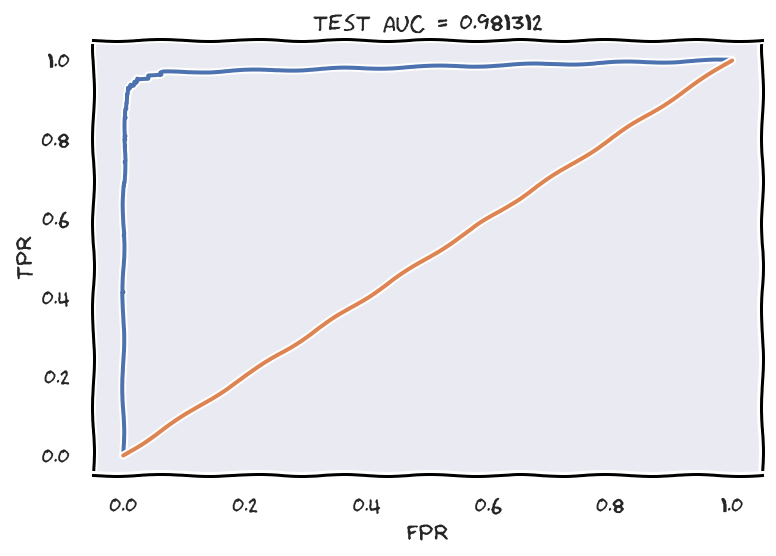

In [14]:
with open(os.path.join('20news_test_predictions.txt')) as pred_file:
    test_prediction = [float(label) 
                             for label in pred_file.readlines()]

auc = roc_auc_score(test_labels, test_prediction)
roc_curve = roc_curve(test_labels, test_prediction)

with plt.xkcd():
    plt.plot(roc_curve[0], roc_curve[1]);
    plt.plot([0,1], [0,1])
    plt.xlabel('FPR'); 
    plt.ylabel('TPR'); 
    plt.title('test AUC = %f' % (auc)); 
    plt.axis([-0.05,1.05,-0.05,1.05]);